In [1]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

from torchvision import datasets, transforms
from torchviz import make_dot



import utils
from utils.dataset import SegmentationDataSet
from utils.printer import source_printer
from utils.printer import target_printer
import utils.model as model
from utils.model import UNet
from utils.model import YNet
from utils.model import Recons_net
from utils.model import ClassifNet
from utils.utils import getLossAccuracyOnDataset
from utils.utils import preprocessing
from utils.utils import IoU
from utils.utils import postprocessing
from utils.utils import dice_coeff
from utils.utils import multiclass_dice_coeff
from utils.utils import dice_loss
from utils.utils import smooth


# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [2]:
def img_show(img, cmap="gray", title=""):
    # cv.namedWindow(title, cv.WINDOW_NORMAL)
    # cv.imshow(title, img)
    print(title)
    plt.imshow(img, cmap)
    # display that image
    plt.show()


def tensor_to_image(tensor):
    transform = transforms.ToPILImage()
    return transform(tensor)


def image_to_tensor(image):
    transform_1 = transforms.ToPILImage()
    transform_2 = transforms.ToTensor()
    img_tensor = transform_2(transform_1(image))
    return img_tensor


In [3]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
# Refaire nos data folder et tout pour que ce soit
# au format demandé par le dataloader

training_set_name = "MNIST_TEACHER"


dataset_folder = "xxx"
train_list = dataset_folder+"patches/xxx.txt"
test_list = dataset_folder+"patches/xxx.txt"


# Number of workers for dataloader
workers = 10

# Batch size during training (low batch_size if there are memory issues)
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
learning_rate = 1e-5  # e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Saves every batch_save_interval
batch_save_interval = 2

# some net variable
amp = False


saving_folder = "../Data/Saves/" + training_set_name

# We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch
if not os.path.exists(saving_folder):
    os.mkdir(saving_folder)
    os.mkdir(saving_folder+"/loss-dice_listes")
    os.mkdir(saving_folder+"/newtork_weigths")
    os.mkdir(saving_folder+"/training_monitoring")

log_file = open(saving_folder+"/log+"+"_"+date+"_"+heure+".txt", "w")

log_file.write("dataset_folder :"+dataset_folder+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_net="+str(learning_rate)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")
log_file.close()


In [4]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print("device ID", device)  #On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("nom du GPU", torch.cuda.get_device_name(device)) #On vérifie son "nom"

torch.cuda.empty_cache()


number of gpus : 1
device ID cuda:0
nom du GPU NVIDIA GeForce GTX 1080 Ti


# Load Dataset

/home/jonas/miniconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


images source :  torch.Size([10, 1, 28, 28])
mask source : torch.Size([10])
tensor([4, 3, 8, 8, 9, 0, 8, 5, 9, 2])


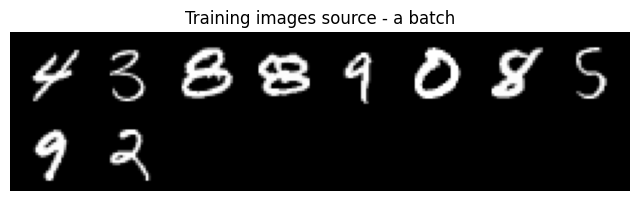

In [5]:
# For data augmentation

geometric_augs = [
    #transforms.Resize((256, 256)), # Makes it easier to process using net
    #transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(45),
]

color_augs = [
    #transforms.ColorJitter(hue=0.05, saturation=0.4)
]


def make_tfs(augs):
    return transforms.Compose([transforms.ToPILImage()]+augs + [transforms.ToTensor()])


tfs = transforms.Compose(geometric_augs)

"""
# Importation des images et masques de i3
dataset = SegmentationDataSet(root=dataset_folder,
                              list_path=train_list,
                              transform_img=make_tfs(
                                  geometric_augs + color_augs),
                              transform_label=make_tfs(geometric_augs)
                              )
"""

dataset_train = dset.MNIST("/var/tmp/", train=True, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.1307,), (0.3081,))
                           ]))

dataset_test = dset.MNIST("/var/tmp/", train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.1307,), (0.3081,))
                          ]))

# Dataloader pour i3
dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=workers)

dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=workers)

batch = next(iter(dataloader_train))

# On affiche quelques exemple du batch pour vérifier qu'on a bien importé les données
print("images source : ", batch[0].shape)
print("mask source :", batch[1].shape)


print(batch[1])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images source - a batch")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(
    device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


# Neural net architecture

## Load or create neural net

In [6]:

# bilinear set by default to False here
#unet = UNet(n_channels=3, n_classes=2, bilinear=False)
net = model.TeacherNetwork(1, 10)
# Load NN
if False:
    state_dict = torch.load(
        "/home/jonas/Documents/Unistra_2020_2024_git/2022_2023/TER/Data/Saves/MNIST_TEACHER/newtork_weigths/net_acc0.998_loss0.005.pth")
    net.load_state_dict(state_dict)
net.to(device=device)

#On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

if (device.type == 'cuda') and (ngpu > 1):
    print("Data Parallel")
    net = nn.DataParallel(net, list(range(ngpu)))




We are running U-Net on : NVIDIA GeForce GTX 1080 Ti


In [7]:
#Loss, optimizers and friends for UNet

criterion_net = nn.CrossEntropyLoss()

scheduler_params = dict(max_lr=1e-3,
                        epochs=num_epochs, steps_per_epoch=len(dataloader_train))
optimizer_global = optim.AdamW(list(net.parameters()))
scheduler_global = optim.lr_scheduler.OneCycleLR(optimizer_global, **scheduler_params)  # goal: maximize Dice score
grad_scaler_global = torch.cuda.amp.GradScaler(enabled=amp)  #Default parameter

# Training

In [8]:
def trainStep(network, criterion, optimizer, X, y):
	"""
	One training step of the network: forward prop + backprop + update parameters
	Return: (loss, accuracy) of current batch
	"""
	optimizer.zero_grad()
	outputs = network(X)
	loss = criterion(outputs, y)
	loss.backward()
	optimizer.step()
	accuracy = float(torch.sum(torch.argmax(
		outputs, dim=1) == y).item()) / y.shape[0]
	return loss, accuracy

Epoch 13/100: 100%|██████████| 60000/60000 [00:15<00:00, 3968.18img/s, accuracy (batch)=0.998, loss (batch)=0.00543]

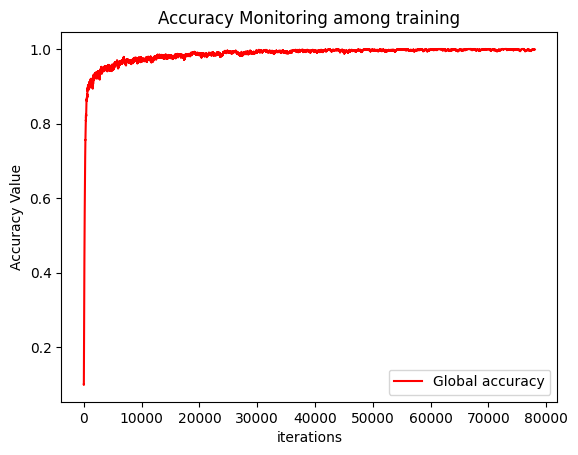

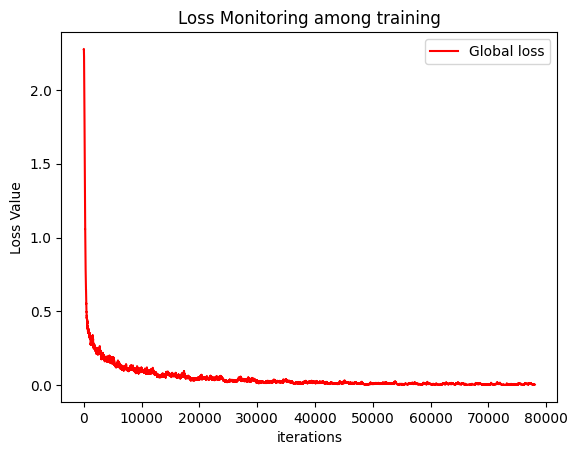

Epoch 15/100: 100%|██████████| 60000/60000 [00:15<00:00, 3632.32img/s, accuracy (batch)=0.998, loss (batch)=0.00497]

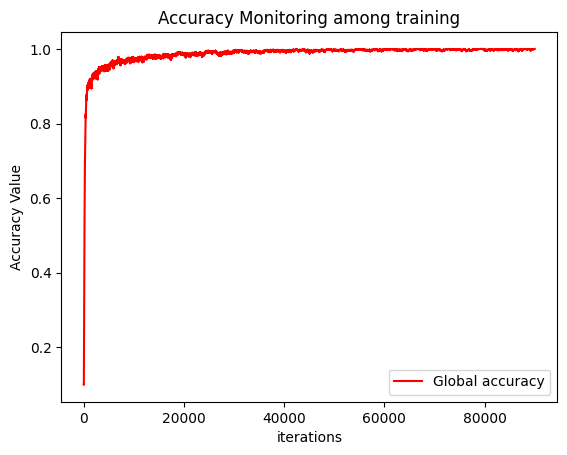

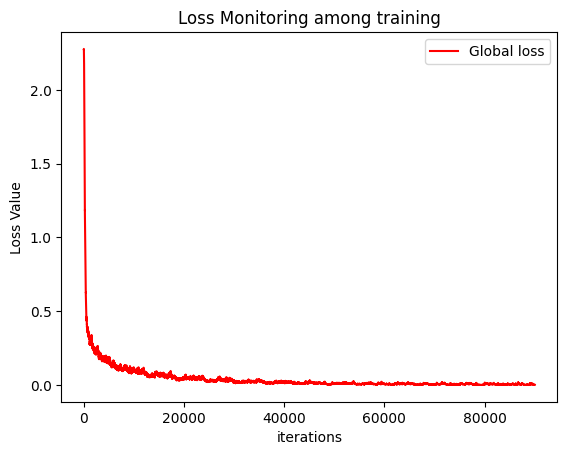

Epoch 16/100:  67%|██████▋   | 40110/60000 [00:10<00:05, 3925.87img/s, accuracy (batch)=0.998, loss (batch)=0.00531]


KeyboardInterrupt: 

In [9]:
global_step = 0
n_train = len(dataset_train)
print(n_train)

print("Starting Training Loop...")

source_dice = []
intervalle = []

L_seg_list = []

loss_list = []
acc_list = []

L_s_list = []

compteur_plot = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    cpt_it = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='img') as pbar:

        for i, data in enumerate(dataloader_train, 0):
            net.train()
            cpt_it += 1

            X, y  = data

            X = X.to(
                device=device, dtype=torch.float32)
            y = y.to(
                device=device, dtype=torch.long)

            # Pass Data Trought net before optimizing everything

            loss, acc = trainStep(net, criterion_net, optimizer_global, X, y)

            L_global = loss


            ###########################################################
            # Evaluation on the Training Set
            ###########################################################

            net.eval()

            intervalle.append(compteur_plot)
            compteur_plot += 1

            global_step += 1
            epoch_loss += loss.item()
            epoch_acc += acc

            pbar.update(X.shape[0])
            pbar.set_postfix(
                **{'loss (batch)': epoch_loss/cpt_it, "accuracy (batch)": epoch_acc/cpt_it})
            # pbar.set_postfix(**{'dice target': dice_target})
            
            loss_list.append(loss.item())
            acc_list.append(acc)
# print("whole epoch target dice mean :", sum(dice_score_target)/cpt_it)
        if (epoch % batch_save_interval == 0):  # and epoch != 0 :
            
            loss_smooth = smooth(loss_list, 0.99)
            acc_smooth = smooth(acc_list, 0.99)

            torch.save(net.state_dict(), saving_folder +
                       "/newtork_weigths/net_acc{:.3f}_loss{:.3f}.pth".format(epoch_acc/cpt_it, epoch_loss/cpt_it))
            # torch.save(ynet.state_dict(), saving_folder+"/newtork_weigths/recons_net_Cell_Seg_UDA_with_recons_4000-4000_"+str(epoch)+"_epochs.pth")
            
            plt.figure(1)
            plt.clf()
            plt.plot(intervalle, acc_smooth, 'r-', label='Global accuracy')
            plt.xlabel("iterations")
            plt.ylabel("Accuracy Value")
            plt.title("Accuracy Monitoring among training")
            plt.legend()
            plt.savefig(saving_folder+"/training_monitoring/acc_" +
                        str(epoch)+"_epoch.png")
            plt.show()
            

            plt.figure(1)
            plt.clf()
            plt.plot(intervalle, loss_smooth, 'r-', label='Global loss')
            plt.xlabel("iterations")
            plt.ylabel("Loss Value")
            plt.title("Loss Monitoring among training")
            plt.legend()
            plt.savefig(saving_folder+"/training_monitoring/loss_" +
                        str(epoch)+"_epoch.png")
            plt.show()
